In [2]:
import os, time
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm
import torchvision.models as models

In [3]:
IMG_DIR  = "/kaggle/input/isic201882/ISIC2018/images_aug_20000"
MASK_DIR = "/kaggle/input/isic201882/ISIC2018/masks_aug_20000"
IMG_EXT  = ".jpg"
MASK_EXT = ".png"

EPOCHS = 5                 
SEED   = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


LR_LIST    = [1e-4, 3e-5, 1e-5]
BATCH_LIST = [4, 8, 16]


DATASET_FRACTIONS = [0.2, 0.4, 0.6, 0.8, 1.0]
VAL_RATIO = 0.2  


Device: cuda


In [4]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [5]:
train_tfms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=20, p=0.7),
    A.Normalize(),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])



/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [6]:
class ISICSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, ids, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path  = os.path.join(self.img_dir, img_id + IMG_EXT)
        mask_path = os.path.join(self.mask_dir, img_id + MASK_EXT)

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(mask_path)
        mask = (mask > 0).astype(np.float32)  

        if self.transform:
            out = self.transform(image=img, mask=mask)
            img = out["image"]
            mask = out["mask"]

        return img, mask.unsqueeze(0)  


In [7]:
all_ids = sorted([
    f.replace(IMG_EXT, "")
    for f in os.listdir(IMG_DIR)
    if f.endswith(IMG_EXT)
])
print("Total IDs:", len(all_ids))
print("Example:", all_ids[:5])


def split_ids(ids, val_ratio=0.2, seed=42):
    rng = np.random.RandomState(seed)
    ids = np.array(ids)
    rng.shuffle(ids)
    n_val = int(len(ids) * val_ratio)
    val_ids = ids[:n_val].tolist()
    tr_ids  = ids[n_val:].tolist()
    return tr_ids, val_ids



Total IDs: 20000
Example: ['ISIC_0000000', 'ISIC_0000000_aug_005082', 'ISIC_0000000_aug_010963', 'ISIC_0000001', 'ISIC_0000001_aug_002315']


In [8]:
@torch.no_grad()
def dice_score_from_logits(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    inter = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    dice = (2 * inter + eps) / (union + eps)
    return dice.mean().item()



In [9]:
def save_model(model, model_name, tag, dice):
    os.makedirs("saved_models", exist_ok=True)
    path = f"saved_models/{model_name}_{tag}_dice{dice:.4f}.pth"
    torch.save(model.state_dict(), path)
    print(f"💾 Saved: {path}")

In [10]:
def train_one_model(model, tr_ld, va_ld, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    hist = {
        "train_loss": [],
        "val_loss": [],
        "train_dice": [],
        "val_dice": []
    }

    for ep in range(1, epochs + 1):
        
        model.train()
        tr_loss_sum, tr_dice_sum = 0.0, 0.0

        loop = tqdm(tr_ld, desc=f"Epoch {ep}/{epochs} [TRAIN]", leave=False)
        for x, y in loop:
            x, y = x.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            tr_loss_sum += loss.item()
            tr_dice_sum += dice_score_from_logits(logits, y)
            loop.set_postfix(loss=loss.item())

        
        model.eval()
        va_loss_sum, va_dice_sum = 0.0, 0.0

        with torch.no_grad():
            loop2 = tqdm(va_ld, desc=f"Epoch {ep}/{epochs} [VAL]", leave=False)
            for x, y in loop2:
                x, y = x.to(DEVICE), y.to(DEVICE)
                logits = model(x)
                loss = criterion(logits, y)

                va_loss_sum += loss.item()
                va_dice_sum += dice_score_from_logits(logits, y)
                loop2.set_postfix(val_loss=loss.item())

        tr_loss = tr_loss_sum / max(1, len(tr_ld))
        va_loss = va_loss_sum / max(1, len(va_ld))
        tr_dice = tr_dice_sum / max(1, len(tr_ld))
        va_dice = va_dice_sum / max(1, len(va_ld))

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_dice"].append(tr_dice)
        hist["val_dice"].append(va_dice)

        print(f"Epoch {ep}/{epochs} | TrainDice={tr_dice:.4f} | ValDice={va_dice:.4f}")

    return hist, model



In [11]:
class ConvBlock(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(i, o, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(o, o, 3, 1, 1), nn.ReLU(True),
        )
    def forward(self, x):
        return self.net(x)

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, (1, 1)).view(b, c)
        y = self.fc1(y)
        y = F.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [12]:
class ResNet34_SE_UNet(nn.Module):
    def __init__(self):
        super().__init__()
        r = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        self.e0 = nn.Sequential(r.conv1, r.bn1, r.relu)  
        self.e1 = nn.Sequential(r.maxpool, r.layer1)     
        self.e2 = r.layer2                               
        self.e3 = r.layer3                               
        self.e4 = r.layer4                               

        self.se1 = SEBlock(64)
        self.se2 = SEBlock(128)
        self.se3 = SEBlock(256)
        self.se4 = SEBlock(512)

        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.d3 = ConvBlock(512 + 256, 256)
        self.d2 = ConvBlock(256 + 128, 128)
        self.d1 = ConvBlock(128 + 64, 64)
        self.d0 = ConvBlock(64 + 64, 64)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        a = self.e0(x)     
        b = self.e1(a)     
        b = self.se1(b)
        c = self.e2(b)     
        c = self.se2(c)
        d = self.e3(c)     
        d = self.se3(d)
        e = self.e4(d)     
        e = self.se4(e)

        x = self.d3(torch.cat([self.up(e), d], 1))
        x = self.d2(torch.cat([self.up(x), c], 1))
        x = self.d1(torch.cat([self.up(x), b], 1))
        x = self.d0(torch.cat([self.up(x), a], 1))
        x = self.up(x)
        return self.out(x)



In [ ]:
model_name = "ResNet34_SE_UNet"

best_score = -1
best_cfg = None

tr_ids_full, va_ids_full = split_ids(all_ids, val_ratio=VAL_RATIO, seed=SEED)

for lr in LR_LIST:
    for batch in BATCH_LIST:
        print("\n" + "="*80)
        print(f"TUNING: LR={lr} | BATCH={batch} | EPOCHS={EPOCHS}")
        print("="*80)

        set_seed(SEED)

        tr_ds = ISICSegDataset(IMG_DIR, MASK_DIR, tr_ids_full, transform=train_tfms)
        va_ds = ISICSegDataset(IMG_DIR, MASK_DIR, va_ids_full, transform=val_tfms)

        tr_ld = DataLoader(tr_ds, batch_size=batch, shuffle=True, num_workers=0, drop_last=True)
        va_ld = DataLoader(va_ds, batch_size=batch, shuffle=False, num_workers=0)

        model = ResNet34_SE_UNet().to(DEVICE)

        hist, trained = train_one_model(model, tr_ld, va_ld, epochs=EPOCHS, lr=lr)

        val_dice = hist["val_dice"][-1]
        print(f"✅ FINAL Val Dice: {val_dice:.4f}")

        if val_dice > best_score:
            best_score = val_dice
            best_cfg = (lr, batch)
            save_model(trained, model_name, f"BEST_LR{lr}_B{batch}", val_dice)

print("\n" + "="*80)
print("🏆 BEST HYPERPARAMETERS")
print("="*80)
print(f"Best LR    : {best_cfg[0]}")
print(f"Best Batch : {best_cfg[1]}")
print(f"Best Dice  : {best_score:.4f}")


TUNING: LR=0.0001 | BATCH=4 | EPOCHS=5
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 228MB/s]


Epoch 1/5 | TrainDice=0.8253 | ValDice=0.8572


Epoch 2/5 | TrainDice=0.8737 | ValDice=0.8807


Epoch 3/5 | TrainDice=0.8810 | ValDice=0.8804


Epoch 4/5 | TrainDice=0.8855 | ValDice=0.8734


Epoch 5/5 | TrainDice=0.8896 | ValDice=0.8843
✅ FINAL Val Dice: 0.8843
💾 Saved: saved_models/ResNet34_SE_UNet_BEST_LR0.0001_B4_dice0.8843.pth

TUNING: LR=0.0001 | BATCH=8 | EPOCHS=5


Epoch 1/5 | TrainDice=0.8134 | ValDice=0.8794


Epoch 2/5 | TrainDice=0.8792 | ValDice=0.8656


Epoch 3/5 | TrainDice=0.8858 | ValDice=0.8917


Epoch 4/5 | TrainDice=0.8905 | ValDice=0.8981


Epoch 5/5 | TrainDice=0.8926 | ValDice=0.8987
✅ FINAL Val Dice: 0.8987
💾 Saved: saved_models/ResNet34_SE_UNet_BEST_LR0.0001_B8_dice0.8987.pth

TUNING: LR=0.0001 | BATCH=16 | EPOCHS=5


Epoch 1/5 | TrainDice=0.7772 | ValDice=0.8790


Epoch 2/5 | TrainDice=0.8804 | ValDice=0.8794


Epoch 3/5 | TrainDice=0.8881 | ValDice=0.8909


Epoch 4/5 | TrainDice=0.8939 | ValDice=0.8992


Epoch 5/5 | TrainDice=0.8972 | ValDice=0.8982
✅ FINAL Val Dice: 0.8982

TUNING: LR=3e-05 | BATCH=4 | EPOCHS=5


Epoch 1/5 | TrainDice=0.8076 | ValDice=0.8646


Epoch 2/5 | TrainDice=0.8792 | ValDice=0.8807


Epoch 3/5 | TrainDice=0.8887 | ValDice=0.8804


Epoch 4/5 | TrainDice=0.8930 | ValDice=0.8927


Epoch 5/5 | TrainDice=0.8970 | ValDice=0.8961
✅ FINAL Val Dice: 0.8961

TUNING: LR=3e-05 | BATCH=8 | EPOCHS=5


Epoch 1/5 | TrainDice=0.7768 | ValDice=0.8753


Epoch 2/5 | TrainDice=0.8794 | ValDice=0.8783


Epoch 3/5 | TrainDice=0.8903 | ValDice=0.8921


Epoch 4/5 | TrainDice=0.8955 | ValDice=0.8995


Epoch 5/5 | TrainDice=0.8998 | ValDice=0.9020
✅ FINAL Val Dice: 0.9020
💾 Saved: saved_models/ResNet34_SE_UNet_BEST_LR3e-05_B8_dice0.9020.pth

TUNING: LR=3e-05 | BATCH=16 | EPOCHS=5


Epoch 1/5 | TrainDice=0.7155 | ValDice=0.8646


Epoch 2/5 | TrainDice=0.8753 | ValDice=0.8710


Epoch 3/5 | TrainDice=0.8886 | ValDice=0.8883


Epoch 4/5 | TrainDice=0.8954 | ValDice=0.8982


Epoch 5/5 | TrainDice=0.9002 | ValDice=0.9041
✅ FINAL Val Dice: 0.9041
💾 Saved: saved_models/ResNet34_SE_UNet_BEST_LR3e-05_B16_dice0.9041.pth

TUNING: LR=1e-05 | BATCH=4 | EPOCHS=5


Epoch 1/5 | TrainDice=0.7478 | ValDice=0.8359


Epoch 2/5 | TrainDice=0.8683 | ValDice=0.8680


Epoch 3/5 | TrainDice=0.8806 | ValDice=0.8784


Epoch 4/5 | TrainDice=0.8871 | ValDice=0.8813


Epoch 5/5 | TrainDice=0.8922 | ValDice=0.8907
✅ FINAL Val Dice: 0.8907

TUNING: LR=1e-05 | BATCH=8 | EPOCHS=5


Epoch 1/5 | TrainDice=0.6829 | ValDice=0.8331


Epoch 2/5 | TrainDice=0.8611 | ValDice=0.8451


Epoch 3/5 | TrainDice=0.8763 | ValDice=0.8761


Epoch 4/5 | TrainDice=0.8842 | ValDice=0.8854


Epoch 5/5 | TrainDice=0.8894 | ValDice=0.8938
✅ FINAL Val Dice: 0.8938

TUNING: LR=1e-05 | BATCH=16 | EPOCHS=5


Epoch 1/5 | TrainDice=0.5759 | ValDice=0.8185


Epoch 2/5 | TrainDice=0.8508 | ValDice=0.8665


Epoch 3/5 | TrainDice=0.8705 | ValDice=0.8778


Epoch 4/5 [TRAIN]:  63%|██████▎   | 629/1000 [05:36<02:41,  2.29it/s, loss=0.0944]

In [13]:

best_lr = 3e-5
best_batch = 16


In [ ]:
import os, json

CKPT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, history, ckpt_path):
    payload = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optim_state": optimizer.state_dict(),
        "history": history,
    }
    torch.save(payload, ckpt_path)

def load_checkpoint(model, optimizer, ckpt_path, device):
    payload = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(payload["model_state"])
    optimizer.load_state_dict(payload["optim_state"])
    start_epoch = payload["epoch"] + 1
    history = payload.get("history", None)
    return start_epoch, history

def save_history_json(history, path):
    with open(path, "w") as f:
        json.dump(history, f)


In [14]:
sizes_curve = []
train_curve = []
val_curve = []

print("\n" + "="*80)
print("DATASET SIZE CURVE (Train/Val Dice vs dataset size)")
print("="*80)

for frac in DATASET_FRACTIONS:
    set_seed(SEED)

    n = int(len(all_ids) * frac)
    ids_subset = all_ids[:n]  

    tr_ids, va_ids = split_ids(ids_subset, val_ratio=VAL_RATIO, seed=SEED)

    tr_ds = ISICSegDataset(IMG_DIR, MASK_DIR, tr_ids, transform=train_tfms)
    va_ds = ISICSegDataset(IMG_DIR, MASK_DIR, va_ids, transform=val_tfms)

    tr_ld = DataLoader(tr_ds, batch_size=best_batch, shuffle=True, num_workers=0, drop_last=True)
    va_ld = DataLoader(va_ds, batch_size=best_batch, shuffle=False, num_workers=0)

    model = ResNet34_SE_UNet().to(DEVICE)

    print("\n" + "-"*70)
    print(f"DATA FRACTION: {int(frac*100)}% | N={n} | LR={best_lr} | BATCH={best_batch}")
    print("-"*70)

    hist, _ = train_one_model(model, tr_ld, va_ld, epochs=EPOCHS, lr=best_lr)

    sizes_curve.append(n)
    train_curve.append(hist["train_dice"][-1])
    val_curve.append(hist["val_dice"][-1])



DATASET SIZE CURVE (Train/Val Dice vs dataset size)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 175MB/s] 



----------------------------------------------------------------------
DATA FRACTION: 20% | N=4000 | LR=3e-05 | BATCH=16
----------------------------------------------------------------------


Epoch 1/5 | TrainDice=0.5121 | ValDice=0.8999


Epoch 2/5 | TrainDice=0.9076 | ValDice=0.9201


Epoch 3/5 | TrainDice=0.9248 | ValDice=0.9311


Epoch 4/5 | TrainDice=0.9310 | ValDice=0.9335


Epoch 5/5 | TrainDice=0.9346 | ValDice=0.9305

----------------------------------------------------------------------
DATA FRACTION: 40% | N=8000 | LR=3e-05 | BATCH=16
----------------------------------------------------------------------


Epoch 1/5 | TrainDice=0.6410 | ValDice=0.9064


Epoch 2/5 | TrainDice=0.9113 | ValDice=0.9216


Epoch 3/5 | TrainDice=0.9216 | ValDice=0.9272


Epoch 4/5 | TrainDice=0.9271 | ValDice=0.9304


Epoch 5/5 | TrainDice=0.9300 | ValDice=0.9289

----------------------------------------------------------------------
DATA FRACTION: 60% | N=12000 | LR=3e-05 | BATCH=16
----------------------------------------------------------------------


Epoch 1/5 | TrainDice=0.6689 | ValDice=0.8704


Epoch 2/5 | TrainDice=0.8842 | ValDice=0.8973


Epoch 3/5 | TrainDice=0.8986 | ValDice=0.9059


Epoch 4/5 | TrainDice=0.9068 | ValDice=0.9099


Epoch 5/5 | TrainDice=0.9118 | ValDice=0.9076

----------------------------------------------------------------------
DATA FRACTION: 80% | N=16000 | LR=3e-05 | BATCH=16
----------------------------------------------------------------------


Epoch 1/5 | TrainDice=0.6712 | ValDice=0.8611


Epoch 2/5 | TrainDice=0.8707 | ValDice=0.8813


Epoch 3/5 | TrainDice=0.8832 | ValDice=0.8845


Epoch 4/5 | TrainDice=0.8916 | ValDice=0.8932


Epoch 5/5 | TrainDice=0.8980 | ValDice=0.8903

----------------------------------------------------------------------
DATA FRACTION: 100% | N=20000 | LR=3e-05 | BATCH=16
----------------------------------------------------------------------


Epoch 1/5 | TrainDice=0.7173 | ValDice=0.8723


Epoch 2/5 | TrainDice=0.8752 | ValDice=0.8804


Epoch 3/5 | TrainDice=0.8888 | ValDice=0.8908


Epoch 4/5 | TrainDice=0.8962 | ValDice=0.9010


Epoch 5/5 | TrainDice=0.8996 | ValDice=0.9034


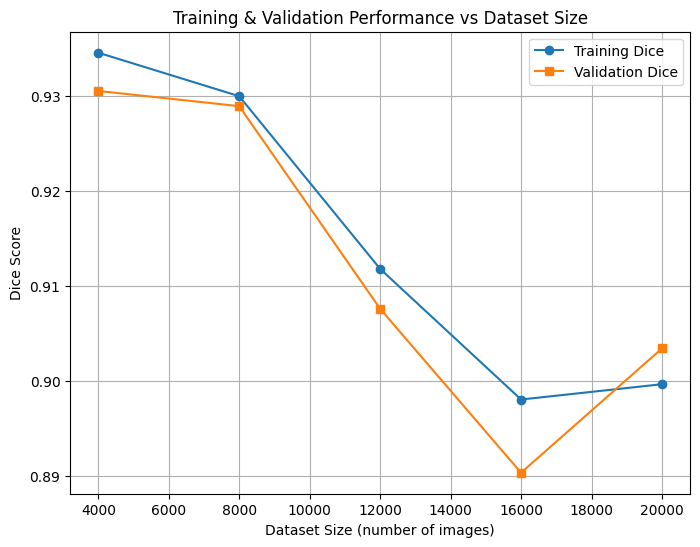


Curve points:
N=  4000 | TrainDice=0.9346 | ValDice=0.9305
N=  8000 | TrainDice=0.9300 | ValDice=0.9289
N= 12000 | TrainDice=0.9118 | ValDice=0.9076
N= 16000 | TrainDice=0.8980 | ValDice=0.8903
N= 20000 | TrainDice=0.8996 | ValDice=0.9034


In [15]:
plt.figure(figsize=(8, 6))
plt.plot(sizes_curve, train_curve, marker='o', label="Training Dice")
plt.plot(sizes_curve, val_curve, marker='s', label="Validation Dice")
plt.xlabel("Dataset Size (number of images)")
plt.ylabel("Dice Score")
plt.title("Training & Validation Performance vs Dataset Size")
plt.grid(True)
plt.legend()
plt.show()

print("\nCurve points:")
for n, td, vd in zip(sizes_curve, train_curve, val_curve):
    print(f"N={n:6d} | TrainDice={td:.4f} | ValDice={vd:.4f}")